In [1]:
import keras
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split
import shutil
import glob
from keras.models import Model
from keras.layers import Input,Conv2D, MaxPooling2D, BatchNormalization,Flatten,Dense

Using TensorFlow backend.


In [2]:
DATA_PATH = './att_faces'
TRAIN_PATH = './train'
VALIDATION = './val'
TEST_PATH = './test'

In [3]:
def create_paths(*paths):
    for i in paths:
        if os.path.exists(i): continue
        os.makedirs(i)
    

In [4]:
files=os.listdir(DATA_PATH)

In [5]:
folders= [i for i in files if i.startswith('s')]
num_classes_original = len(folders)
training_sampling_ratio = 0.8 
num_train_folders = int(0.8 *num_classes_original) 
train_folders = np.random.choice(folders,num_train_folders,replace=False).tolist()
remaining_folders= np.setdiff1d(folders,train_folders)
validation_folders = [remaining_folders[i] for i in range(4)]
test_folders= np.setdiff1d(remaining_folders,validation_folders)

In [6]:
len(test_folders)

4

In [7]:
len(train_folders)

32

In [8]:
print(train_folders)

['s1', 's33', 's27', 's10', 's6', 's38', 's2', 's29', 's19', 's4', 's9', 's23', 's15', 's39', 's21', 's7', 's36', 's17', 's31', 's12', 's37', 's16', 's3', 's34', 's5', 's24', 's26', 's25', 's13', 's8', 's32', 's20']


In [10]:
validation_folders

['s11', 's14', 's18', 's22']

In [11]:
test_folders

array(['s28', 's30', 's35', 's40'],
      dtype='<U3')

## COPY FILES TO RESPECTIVE DIRECTORIES

In [16]:
def copy_files(folders,path):
    for folder in folders:
        
        dest=path+'/'+str(folder)
        src= os.path.join(DATA_PATH,folder)
        os.makedirs(dest)
        for i in os.listdir(src):
            shutil.copy(src+'/'+str(i),dest)

#UNCOMMENT BELOW LINES ON FIRST RUN ONLY
copy_files(train_folders,TRAIN_PATH)
copy_files(validation_folders,VALIDATION) #don't change this order
copy_files(test_folders,TEST_PATH)



In [17]:
!ls

 att_faces  'att_faces (copy)'	 data.ipynb   model.png   test	 train	 val


In [14]:
from keras.preprocessing.image import ImageDataGenerator
import cv2

In [20]:
NUM_CLASSES= len(train_folders)

In [119]:
def make_dataset(path):
    folders= os.listdir(path)
    y=[]
    x=[]
    for folder in folders:
        
        files=os.listdir(os.path.join(path,folder))
        
        for file in files:
            #print(os.path.join(path,folder,file))
            y+=[folder]
            
            """
            Before adding to the data 
            * read the image
            * resize the image
            * make the image 3d 
            
            """
            x+= [cv2.resize(cv2.imread(os.path.join(path,folder,file),0)/255,(56,46)).reshape(56,46,1)]
            
    print(len(x))
    return x,y
            

In [120]:
train_x,train_y = make_dataset(TRAIN_PATH)
val_x,val_y = make_dataset(VALIDATION)
test_x,test_y = make_dataset(TEST_PATH)

320
40
40


## SAMPLES DISTRIBUTION 

In [24]:
def printer(*args):
    x=[]
    for i in args:
        x+=[len(i)]
    return x
        
print("SAMPLES IN \nTRAINING SET : {0}\nTEST SET : {1}\nVALIDATION SET : {2}".format(*printer(train_x,test_x,val_x)))

SAMPLES IN 
TRAINING SET : 320
TEST SET : 40
VALIDATION SET : 40


In [31]:
def model(input_shape):
    
    """
    function abstraction for network1 and network2
    
    """
    inp= Input(shape=input_shape)
    #Convolution layer 1
    x= Conv2D(16,(3,3),activation='relu',padding='same')(inp)
    x= BatchNormalization()(x)
    x= MaxPooling2D()(x)
    #Convolution layer 2
    x= Conv2D(32,(3,3),activation='selu',padding='same')(x)
    x= BatchNormalization()(x)
    x= MaxPooling2D()(x)
    #Convolution layer 3
    x= Conv2D(64,(3,3),activation='selu',padding='same')(x)
    x= BatchNormalization()(x)
    #Convolution layer 4
    x= Conv2D(128,(3,3),activation='selu',padding='same')(x)
    x= MaxPooling2D()(x) 
    x= Flatten()(x)
    #Embeddings we will finally be using 
    x= Dense(128)(x)
    
    model= Model(inputs=inp,outputs=x)
    
    return model

In [117]:
input_shape=(56,46,1)
#DEFINING INPUT LAYER FOR NETWORK1
INPUT_1= Input(shape=input_shape)
#DEFINING INPUT LAYER FOR NETWORK2
INPUT_2=Input(shape=input_shape)

In [33]:
MODEL= model(input_shape)

SIAMESE_NET1_y= MODEL(INPUT_1)

SIAMESE_NET2_y=MODEL(INPUT_2)



In [116]:
def contrastive_loss(y_1,y_2,margin=1):
    """
    Taken: siamian mnist example in keras 
    
    """

    return K.mean((1-y_true)*K.square(y_pred)+(y_true)*K.square(K.maximum(margin-y_pred,0)))

In [35]:
def euclidean_distance(y1,y2):
    
    return K.sqrt(K.sum(K.square(y1-y2),axis=1,keepdims=True))
    

## A NOTE ON HOW THE LABELS AND THE CONTRASTIVE OUTPUT WORKS

<pre>
y_pred : the distance output , if it is less than 0.5 then the label assigned is 0
y_true : 0 for both are same faces
         1 for both are different faces </pre>

In [38]:
def preprocess_dataset(*data_matrices):
    
    """
    This function is only for the dataset during training process .
    It assumes the step of resizing the images to 56 px X 46 px has been
    done already
    
    """
    output=[]
    for data_matrix in data_matrices:
        data_matrix =np.array(data_matrix)/255
        output.append(data_matrix)
    return output
    

In [95]:
train, val , test = map(np.array,preprocess_dataset(train_x,val_x,test_x))
train_y, val_y,test_y= map(np.array, [train_y,val_y,test_y])

In [40]:
printer(train,val,test)

[320, 40, 40]

In [41]:
def preprocess_image(img):
    """
    resize to 56px X 46px
    reshape to make 3 dimensional
    down scale each pixel by 255
    """
    return img.resize(56,46).reshape(56,46,1)/255

In [42]:
from keras.utils import plot_model
plot_model(MODEL, to_file='model.png')


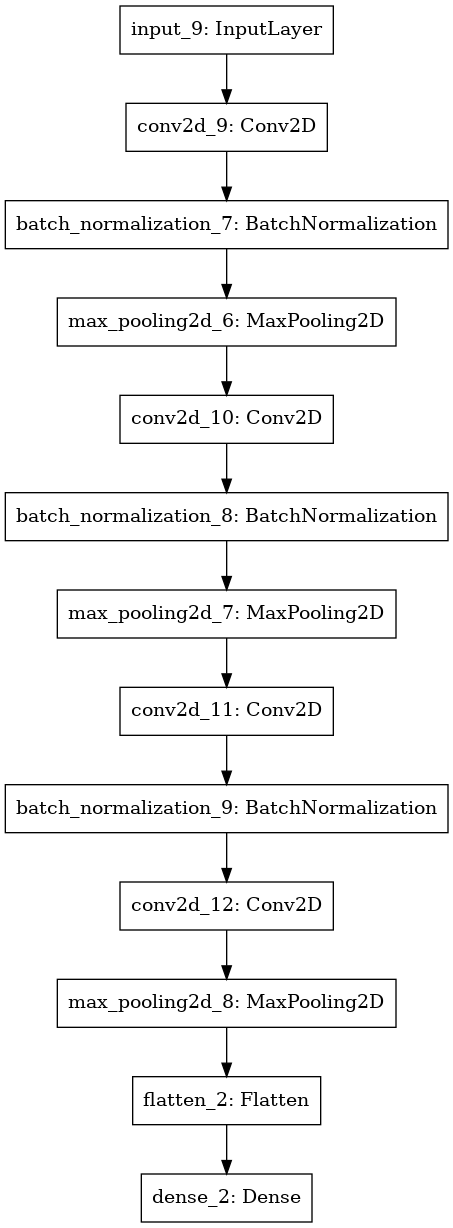

In [43]:
from IPython.display import Image
Image('./model.png')


In [44]:
NUM_CLASSES=32 #train
image_in_each_class= 10 #fixed 

In [118]:
def create_input(X,indices):
    """
    This method is used only for creating pairs for training and validation
    
    
    returns: x = a list with each element as [img1,img2] 
             y = a list of labels 1s and 0s
             
        
               
    """
    x=[]
    y=[]
    
    for i in range(NUM_CLASSES):
        for j in range(9):
            i1,j1 = indices[i][j],indices[i][j+1]
            #print(i1,j1)
            #print(X.shape)
            img1= X[i1]
            
            img2= X[j1]
            #print(img1)
            x+=[img1,img2]
            y+=[0]
            inc=random.randrange(1,NUM_CLASSES)
            dn =(i+inc)%NUM_CLASSES
            i1,j2=indices[i][j],indices[dn][j]
            x+=[X[i1],X[j2]]
            y+=[1]
            
    XY = list(zip(x,y))
    random.shuffle(XY)
    x,y = zip(*XY)
    
    return x,y
    

In [113]:
train_indices = [np.where(train_y==i)[0] for i in T_CLASSES]
#print(train_indices)
T_INPUT,T_LABELS = map(np.array,create_input(train,train_indices))

In [115]:
T_LABELS[:4], T_INPUT.shape

(array([0, 1, 1, 0]), (576, 56, 46, 1))